# **Masking vs no masking investigation**

In [1]:
!git clone https://github.com/hila-chefer/Transformer-Explainability.git

import os
os.chdir(f'./Transformer-Explainability')

!pip install einops

Cloning into 'Transformer-Explainability'...
remote: Enumerating objects: 347, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 347 (delta 99), reused 63 (delta 63), pack-reused 235
Receiving objects: 100% (347/347), 3.23 MiB | 30.31 MiB/s, done.
Resolving deltas: 100% (169/169), done.
/home/18193/sdd-env/env_acne/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/18193/sdd-env/env_acne/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/home/18193/sdd-env/env_acne/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
from PIL import Image
import torchvision.transforms as transforms
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad, EigenGradCAM, LayerCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt
from modules.layers_ours import *
import torch
import numpy as np
import cv2
import timm
from collections import OrderedDict
import sys
sys.path.append('../../')
from src.utils.gcs_utils import *
from src.models.model_factory import model_factory
import pickle
from src.data.skin_functions import masknonskin_original

In [4]:
bucket = get_bucket_gcs('oro-ds-test-bucket')
def download_path_files(name):
    blob = bucket.blob(f'sdd_acne_files/Merged_for_ensemble/{name}')
    blob._chunk_size = 8388608  # 1024 * 1024 B * 16 = 8 MB
    blob.download_to_filename(f'../{name}')

for name in ['vit_exp_142.pth', 'vit_exp_143.pth', 'bit_exp_142.pth', 'bit_exp_143.pth', 'resnext101_32x4d_exp_142.pth', 'resnext101_32x4d_exp_143.pth' ]:
    download_path_files(name)



Here are the list of classes

In [5]:
blob = bucket.blob('sdd_acne_files/Merged_for_ensemble/vit_class_indices.pkl')
pickle_in = blob.download_as_string()
my_dictionary = pickle.loads(pickle_in)
CLS2IDX = my_dictionary

In [6]:
CLS2IDX

{0: 'acne_mixed',
 1: 'acne_scars',
 2: 'atopic_dermatitis',
 3: 'acne_cystic',
 4: 'acne_excoriated',
 5: 'rosacea_inflammatory',
 6: 'rosacea_erythemato_telangiectasique',
 7: 'acne_comedos',
 8: 'peri_oral_dermatitis',
 9: 'seborrheic_keratosis',
 10: 'psoriasis_vulgar',
 11: 'seborrheic_dermatitis',
 12: 'nummular_eczema',
 13: 'tinea_versicolor',
 14: 'chronic_hand_eczema',
 15: 'vulgar_warts',
 16: 'folliculitis',
 17: 'alopecia_androgenic',
 18: 'dyshidrosis',
 19: 'nevus',
 20: 'melasma',
 21: 'alopecia_areata',
 22: 'intertrigo',
 23: 'urticaria',
 24: 'vitiligo',
 25: 'keratosis_pilaris',
 26: 'molluscum',
 27: 'cheilitis_eczematous',
 28: 'tinea_corporis',
 29: 'prurigo_nodularis',
 30: 'actinic_keratosis',
 31: 'genital_warts',
 32: 'plane_warts',
 33: 'pityriasis_rosae',
 34: 'melanonychia',
 35: 'psoriasis_pustular_palmoplantar',
 36: 'granuloma_annulare',
 37: 'psoriasis_guttate',
 38: 'lichen_simplex_chronicus',
 39: 'shingles',
 40: 'herpes_simplex'}

In [7]:
def image_reader(bucket, image):
    image_read = cv2.cvtColor(cv2.imdecode(np.asarray(bytearray(bucket.blob(image).download_as_string()), dtype=np.uint8),cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB)
    return image_read


In [8]:
def image_reader_masking(bucket, image):
    image_read = cv2.imdecode(np.asarray(bytearray(bucket.blob(image).download_as_string()), dtype=np.uint8),cv2.IMREAD_COLOR)
    return image_read

In [9]:
images = ['sdd_acne_files/shanel_images/PXL_20211114_184920576.jpg','sdd_acne_files/shanel_images/PXL_20220419_203530160.jpg',
         'sdd_acne_files/shanel_images/PXL_20220506_215317846.jpg','sdd_acne_files/shanel_images/PXL_20220509_191251054.MP.jpg',
         'sdd_acne_files/shanel_images/PXL_20210312_145539241.jpg']
diseases = [14, 9, 13, 24, 0, 24]

# 1. Vit Model

In [10]:
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=mean, std=std)
transform = transforms.Compose([
    transforms.Resize((224,224)),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])
resizing =  transforms.Resize((224,224))

# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam



def generate_visualization(original_image, attribution_generator, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)

    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def print_top_classes(predictions, **kwargs):    
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

In [11]:
# initialize ViT pretrained
def create_model(model, model_path):
    state_dict = torch.load(f'../{model_path}')
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:]  # remove `module.`
        new_state_dict[name] = v
    print("[Loading Weights to the Model]")
    model.load_state_dict(new_state_dict)
    model.to('cuda')
    model.eval()
    return model

## 1.1 Masking

In [12]:
def show_attention_maps(masking= True):
    fig, axs = plt.subplots(2, len(images), figsize=(20,7))
    model =  vit_LRP(pretrained=True)#timm.create_model('vit_base_patch16_224', num_classes=41)
    num_ftrs = model.head.in_features
    model.head = Linear(num_ftrs, 41)
    if masking:
            model = create_model(model, 'vit_exp_142.pth')
            attribution_generator = LRP(model)
    else:
        model = create_model(model, 'vit_exp_143.pth')
        attribution_generator = LRP(model)
    for i, image in enumerate(images): 
      
        if masking:
            img = image_reader_masking(bucket, image)
            img = masknonskin_original(img)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            img = image_reader(bucket, image)
        
        img = Image.fromarray(img)
        image = transform(img)
        axs[0, i].imshow(resizing(img));
        axs[0, i].axis('off');

        output = model(image.unsqueeze(0).cuda())
        print_top_classes(output)

        # dog 
        # generate visualization for class 243: 'bull mastiff'
        mask_image = generate_visualization(image, attribution_generator, class_index=diseases[i])

        #axs[1].imshow(cat);
        #axs[1].axis('off');
        axs[1, i].imshow(mask_image);
        axs[1, i].axis('off');
    del model
    torch.cuda.empty_cache()
    print(torch.cuda.memory_allocated())


[Loading Weights to the Model]
Top 5 classes:
	18 : dyshidrosis                    		value = 13.570	 prob = 93.7%
	35 : psoriasis_pustular_palmoplantar		value = 10.713	 prob = 5.4%
	14 : chronic_hand_eczema            		value = 8.772	 prob = 0.8%
	10 : psoriasis_vulgar               		value = 6.951	 prob = 0.1%
	2 : atopic_dermatitis              		value = 3.505	 prob = 0.0%


/home/18193/sdd-env/env_acne/lib/python3.7/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Top 5 classes:
	9 : seborrheic_keratosis		value = 10.240	 prob = 56.9%
	19 : nevus               		value = 9.858	 prob = 38.9%
	15 : vulgar_warts        		value = 7.467	 prob = 3.6%
	13 : tinea_versicolor    		value = 4.805	 prob = 0.2%
	31 : genital_warts       		value = 4.395	 prob = 0.2%
Top 5 classes:
	16 : folliculitis     		value = 6.186	 prob = 42.4%
	13 : tinea_versicolor 		value = 5.790	 prob = 28.5%
	25 : keratosis_pilaris		value = 5.181	 prob = 15.5%
	22 : intertrigo       		value = 4.228	 prob = 6.0%
	19 : nevus            		value = 3.357	 prob = 2.5%
Top 5 classes:
	24 : vitiligo             		value = 7.920	 prob = 72.1%
	13 : tinea_versicolor     		value = 6.059	 prob = 11.2%
	20 : melasma              		value = 5.881	 prob = 9.4%
	11 : seborrheic_dermatitis		value = 4.350	 prob = 2.0%
	17 : alopecia_androgenic  		value = 3.789	 prob = 1.2%
Top 5 classes:
	0 : acne_mixed          		value = 11.810	 prob = 57.6%
	1 : acne_scars          		value = 11.445	 prob = 39.9%
	3 : a

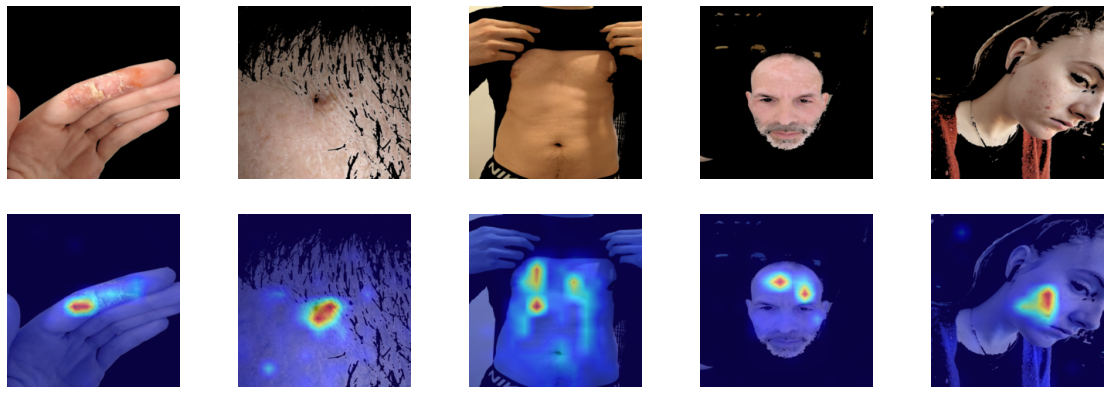

In [12]:
show_attention_maps()

## 1.2 No masking

[Loading Weights to the Model]
Top 5 classes:
	18 : dyshidrosis                    		value = 12.313	 prob = 97.5%
	14 : chronic_hand_eczema            		value = 8.465	 prob = 2.1%
	35 : psoriasis_pustular_palmoplantar		value = 6.317	 prob = 0.2%
	15 : vulgar_warts                   		value = 5.212	 prob = 0.1%
	32 : plane_warts                    		value = 3.447	 prob = 0.0%
Top 5 classes:
	9 : seborrheic_keratosis		value = 12.520	 prob = 92.9%
	19 : nevus               		value = 9.417	 prob = 4.2%
	15 : vulgar_warts        		value = 9.033	 prob = 2.8%
	32 : plane_warts         		value = 5.074	 prob = 0.1%
	31 : genital_warts       		value = 4.184	 prob = 0.0%
Top 5 classes:
	13 : tinea_versicolor		value = 10.950	 prob = 98.0%
	16 : folliculitis    		value = 6.876	 prob = 1.7%
	1 : acne_scars      		value = 4.095	 prob = 0.1%
	7 : acne_comedos    		value = 3.198	 prob = 0.0%
	3 : acne_cystic     		value = 3.070	 prob = 0.0%
Top 5 classes:
	24 : vitiligo             		value = 8.063	 pro

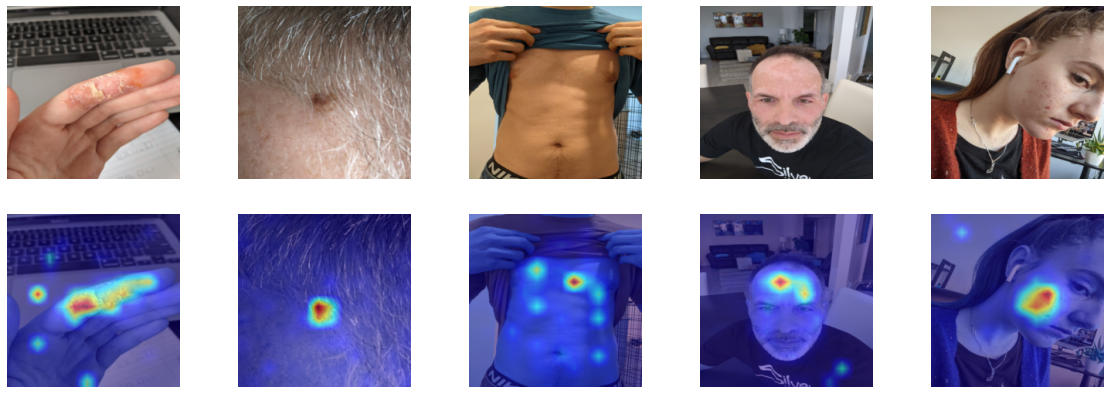

In [13]:
show_attention_maps(False)

# 2. BiT

In [13]:
def show_eigen_grad_cam_maps(model,  target_layers , masking = True):
    fig, axs = plt.subplots(2, len(images), figsize=(20,7))
    for i, image in enumerate(images): 
        img = image_reader(bucket, image)
        
        if masking:
            img = image_reader_masking(bucket, image)
            img = masknonskin_original(img)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            img = image_reader(bucket, image)
        img = Image.fromarray(img)
        
        dog_cat_image = transform(img)
        axs[0, i].imshow(img);
        axs[0, i].axis('off');


        img = image_reader(bucket, image)
       # img = Image.fromarray(img)
        resizing =  transforms.Resize((224,224))

        input_tensor = transform(Image.fromarray(img)).unsqueeze(0).cuda() # Create an input tensor image for your model..
        cam = EigenGradCAM(model=model, target_layers=target_layers, use_cuda=True)
        targets =[ClassifierOutputTarget(diseases[i])]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        heatmap = grayscale_cam[0, :]
        #heatmap = show_cam_on_image(resizing(input_tensor).squeeze(0).view(224,224,3).cpu().numpy(), grayscale_cam)
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = heatmap * 0.4 + img
        cv2.imwrite('./map.jpg', superimposed_img)
        img = np.array(Image.open('./map.jpg'))
        #axs[1].imshow(cat);
        #axs[1].axis('off');
        axs[1, i].imshow(img);
        axs[1, i].axis('off');
        output = model(dog_cat_image.unsqueeze(0).cuda())
        print_top_classes(output)

[Loading Weights to the Model]


/home/18193/sdd-env/env_acne/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Top 5 classes:
	18 : dyshidrosis                    		value = 19.353	 prob = 99.6%
	35 : psoriasis_pustular_palmoplantar		value = 13.488	 prob = 0.3%
	14 : chronic_hand_eczema            		value = 12.209	 prob = 0.1%
	10 : psoriasis_vulgar               		value = 6.768	 prob = 0.0%
	2 : atopic_dermatitis              		value = 6.314	 prob = 0.0%
Top 5 classes:
	19 : nevus               		value = 17.318	 prob = 97.9%
	9 : seborrheic_keratosis		value = 13.308	 prob = 1.8%
	15 : vulgar_warts        		value = 11.093	 prob = 0.2%
	7 : acne_comedos        		value = 9.922	 prob = 0.1%
	4 : acne_excoriated     		value = 8.703	 prob = 0.0%
Top 5 classes:
	13 : tinea_versicolor    		value = 18.034	 prob = 100.0%
	1 : acne_scars          		value = 9.896	 prob = 0.0%
	23 : urticaria           		value = 9.128	 prob = 0.0%
	10 : psoriasis_vulgar    		value = 6.490	 prob = 0.0%
	8 : peri_oral_dermatitis		value = 5.063	 prob = 0.0%
Top 5 classes:
	24 : vitiligo                           		value = 15.5

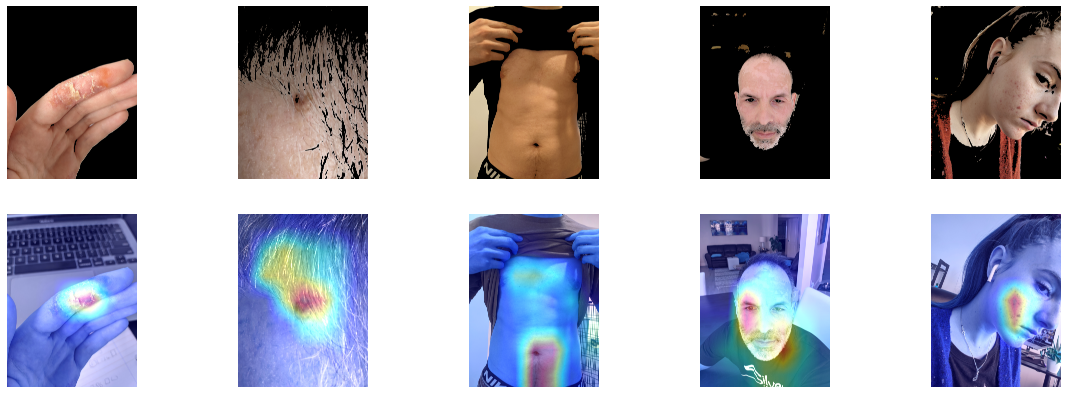

In [13]:
model =  timm.create_model('resnetv2_101x1_bitm', pretrained=True, num_classes=41)
model = create_model(model, 'bit_exp_142.pth')
show_eigen_grad_cam_maps(model,target_layers=model.stages[-1].blocks, masking = True)

[Loading Weights to the Model]
Top 5 classes:
	18 : dyshidrosis                    		value = 30.165	 prob = 100.0%
	14 : chronic_hand_eczema            		value = 15.225	 prob = 0.0%
	35 : psoriasis_pustular_palmoplantar		value = 11.269	 prob = 0.0%
	2 : atopic_dermatitis              		value = 11.010	 prob = 0.0%
	40 : herpes_simplex                 		value = 8.467	 prob = 0.0%
Top 5 classes:
	9 : seborrheic_keratosis		value = 20.936	 prob = 99.8%
	19 : nevus               		value = 14.601	 prob = 0.2%
	15 : vulgar_warts        		value = 12.471	 prob = 0.0%
	30 : actinic_keratosis   		value = 5.710	 prob = 0.0%
	29 : prurigo_nodularis   		value = 5.575	 prob = 0.0%
Top 5 classes:
	13 : tinea_versicolor 		value = 18.792	 prob = 100.0%
	10 : psoriasis_vulgar 		value = 9.464	 prob = 0.0%
	29 : prurigo_nodularis		value = 5.089	 prob = 0.0%
	1 : acne_scars       		value = 4.867	 prob = 0.0%
	23 : urticaria        		value = 4.850	 prob = 0.0%
Top 5 classes:
	24 : vitiligo                    

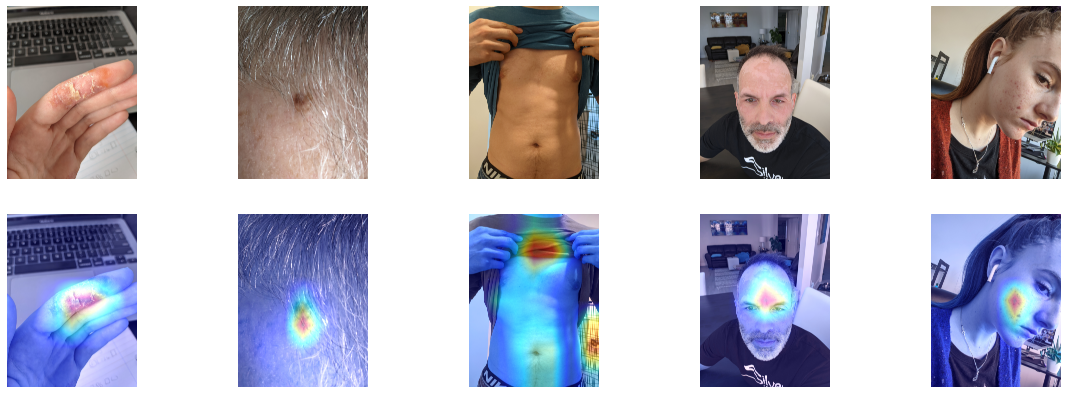

In [14]:
model =  timm.create_model('resnetv2_101x1_bitm', pretrained=True, num_classes=41)
model = create_model(model, 'bit_exp_143.pth')
show_eigen_grad_cam_maps(model,target_layers=model.stages[-1].blocks, masking = False)

# 3. ResNext 32

## 3.1 Masking

[Loading Weights to the Model]


/home/18193/sdd-env/env_acne/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Top 5 classes:
	18 : dyshidrosis                    		value = 11.715	 prob = 97.8%
	35 : psoriasis_pustular_palmoplantar		value = 7.461	 prob = 1.4%
	14 : chronic_hand_eczema            		value = 6.569	 prob = 0.6%
	10 : psoriasis_vulgar               		value = 4.960	 prob = 0.1%
	32 : plane_warts                    		value = 3.462	 prob = 0.0%
Top 5 classes:
	31 : genital_warts       		value = 8.048	 prob = 60.0%
	15 : vulgar_warts        		value = 6.502	 prob = 12.8%
	9 : seborrheic_keratosis		value = 6.467	 prob = 12.3%
	19 : nevus               		value = 6.137	 prob = 8.9%
	25 : keratosis_pilaris   		value = 4.974	 prob = 2.8%
Top 5 classes:
	24 : vitiligo        		value = 9.411	 prob = 82.3%
	13 : tinea_versicolor		value = 7.166	 prob = 8.7%
	1 : acne_scars      		value = 6.643	 prob = 5.2%
	23 : urticaria       		value = 6.183	 prob = 3.3%
	22 : intertrigo      		value = 2.799	 prob = 0.1%
Top 5 classes:
	24 : vitiligo             		value = 9.176	 prob = 94.4%
	13 : tinea_versico

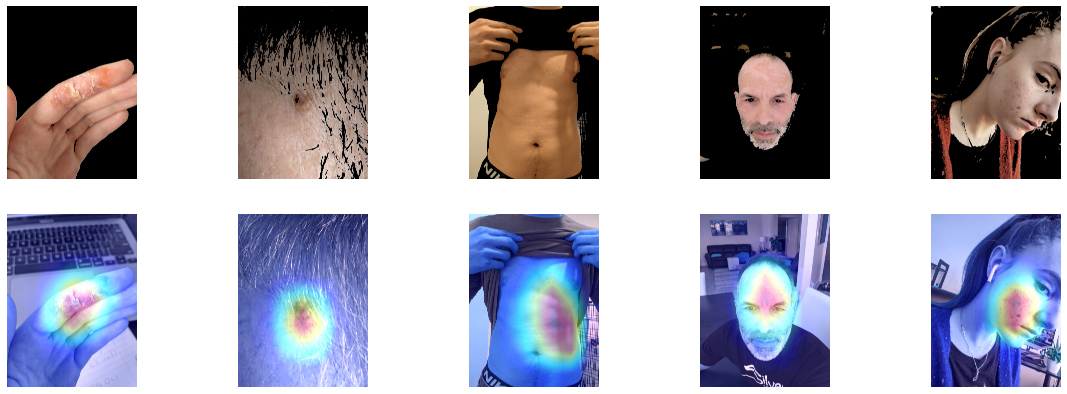

In [14]:
model = model_factory('resnext101_32x4d', 41, freeze_layers=False, percentage_freeze= 0, pretrained=True, ml_decoder=False)
model = create_model(model, 'resnext101_32x4d_exp_142.pth')
show_eigen_grad_cam_maps(model,target_layers=model.features[-1], masking = True)

## 3.2 No Masking

[Loading Weights to the Model]
Top 5 classes:
	18 : dyshidrosis                    		value = 14.074	 prob = 98.2%
	14 : chronic_hand_eczema            		value = 9.679	 prob = 1.2%
	28 : tinea_corporis                 		value = 8.961	 prob = 0.6%
	35 : psoriasis_pustular_palmoplantar		value = 5.674	 prob = 0.0%
	32 : plane_warts                    		value = 4.559	 prob = 0.0%
Top 5 classes:
	19 : nevus               		value = 10.712	 prob = 52.3%
	9 : seborrheic_keratosis		value = 10.617	 prob = 47.5%
	15 : vulgar_warts        		value = 4.582	 prob = 0.1%
	32 : plane_warts         		value = 2.986	 prob = 0.0%
	7 : acne_comedos        		value = 2.344	 prob = 0.0%
Top 5 classes:
	13 : tinea_versicolor		value = 5.890	 prob = 49.7%
	7 : acne_comedos    		value = 4.804	 prob = 16.8%
	1 : acne_scars      		value = 4.238	 prob = 9.5%
	21 : alopecia_areata 		value = 3.683	 prob = 5.5%
	18 : dyshidrosis     		value = 3.091	 prob = 3.0%
Top 5 classes:
	20 : melasma              		value = 8.319	 p

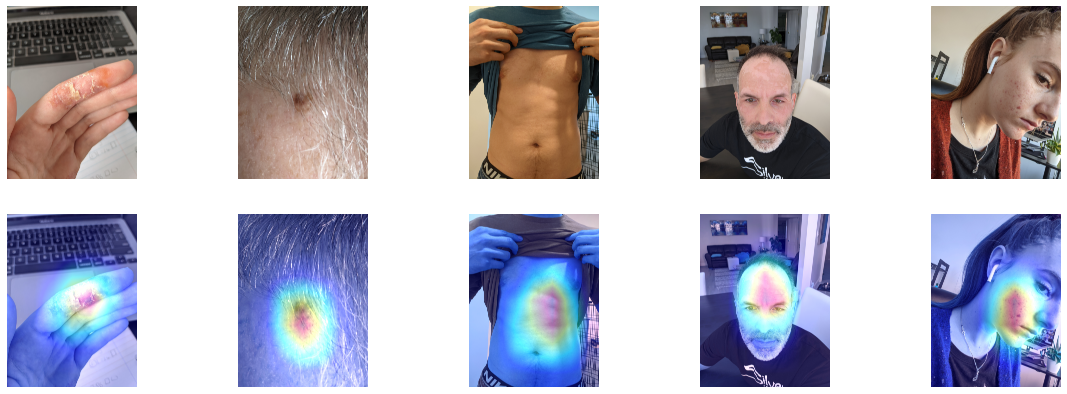

In [15]:
model = model_factory('resnext101_32x4d', 41, freeze_layers=False, percentage_freeze= 0, pretrained=True, ml_decoder=False)
model = create_model(model, 'resnext101_32x4d_exp_143.pth')
show_eigen_grad_cam_maps(model,target_layers=model.features[-1], masking = False)